In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import json
sns.set_style("whitegrid")

def generate_default_plot_env():
    sns.set(font_scale=1.4, style="whitegrid")
    matplotlib.rcParams['pdf.fonttype'] = 42
    matplotlib.rcParams['ps.fonttype'] = 42
    matplotlib.rc('font', family='sans-serif') 
    matplotlib.rc('font', serif='Helvetica Neue') 
    matplotlib.rc('text', usetex='false') 
    matplotlib.rcParams.update({'font.size': 22})
    
    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['ps.fonttype'] = 42
    plt.rc('font', family='sans-serif') 
    plt.rc('font', serif='Helvetica Neue') 
    plt.rc('text', usetex='false') 
    plt.rcParams.update({'font.size': 22})

In [2]:
from mpl_toolkits.basemap import Basemap
from shapely.geometry import Point, MultiPoint
import matplotlib.colors as colors
from matplotlib.colors import rgb2hex
from matplotlib.patches import Polygon, Rectangle

In [3]:
from_nyc_df = pd.read_csv('../data/from_nyc_to_less_walkable.csv')
location_lat_lon_df = pd.read_csv('../data/location_lat_lon.csv')

In [4]:
from_nyc_loc_counts_df = from_nyc_df.groupby('to_loc').count().reset_index().rename(columns={'from_loc':'num_users'})
from_nyc_loc_counts_df.head()

,to_loc,num_users
0,"Albuquerque, NM",9
1,"Alexandria, VA",10
2,"Allentown, PA",41
3,"Alpharetta, GA",50
4,"Anaheim, CA",24


In [5]:
from_nyc_df = from_nyc_df.merge(location_lat_lon_df, how='left', left_on='from_loc', right_on='location', suffixes=['', '_from'])
from_nyc_df = from_nyc_df.merge(location_lat_lon_df, how='left', left_on='to_loc', right_on='location', suffixes=['', '_to'])
from_nyc_df = from_nyc_df.merge(from_nyc_loc_counts_df, how='left', on='to_loc').dropna(subset=['lat_to', 'lon_to'])
from_nyc_df.head()

,to_loc,from_loc,location,lat,lon,location_to,lat_to,lon_to,num_users
0,"Spring, TX","New York, NY","New York, NY",40.75,-73.99,"Spring, TX",30.06,-95.37,84
1,"Johnstown, PA","New York, NY","New York, NY",40.75,-73.99,"Johnstown, PA",40.32,-78.93,132
2,"Fremont, CA","New York, NY","New York, NY",40.75,-73.99,"Fremont, CA",37.56,-122.00,97
3,"Castle Rock, CO","New York, NY","New York, NY",40.75,-73.99,"Castle Rock, CO",39.33,-104.83,98
4,"Los Angeles, CA","New York, NY","New York, NY",40.75,-73.99,"Los Angeles, CA",33.95,-118.21,310


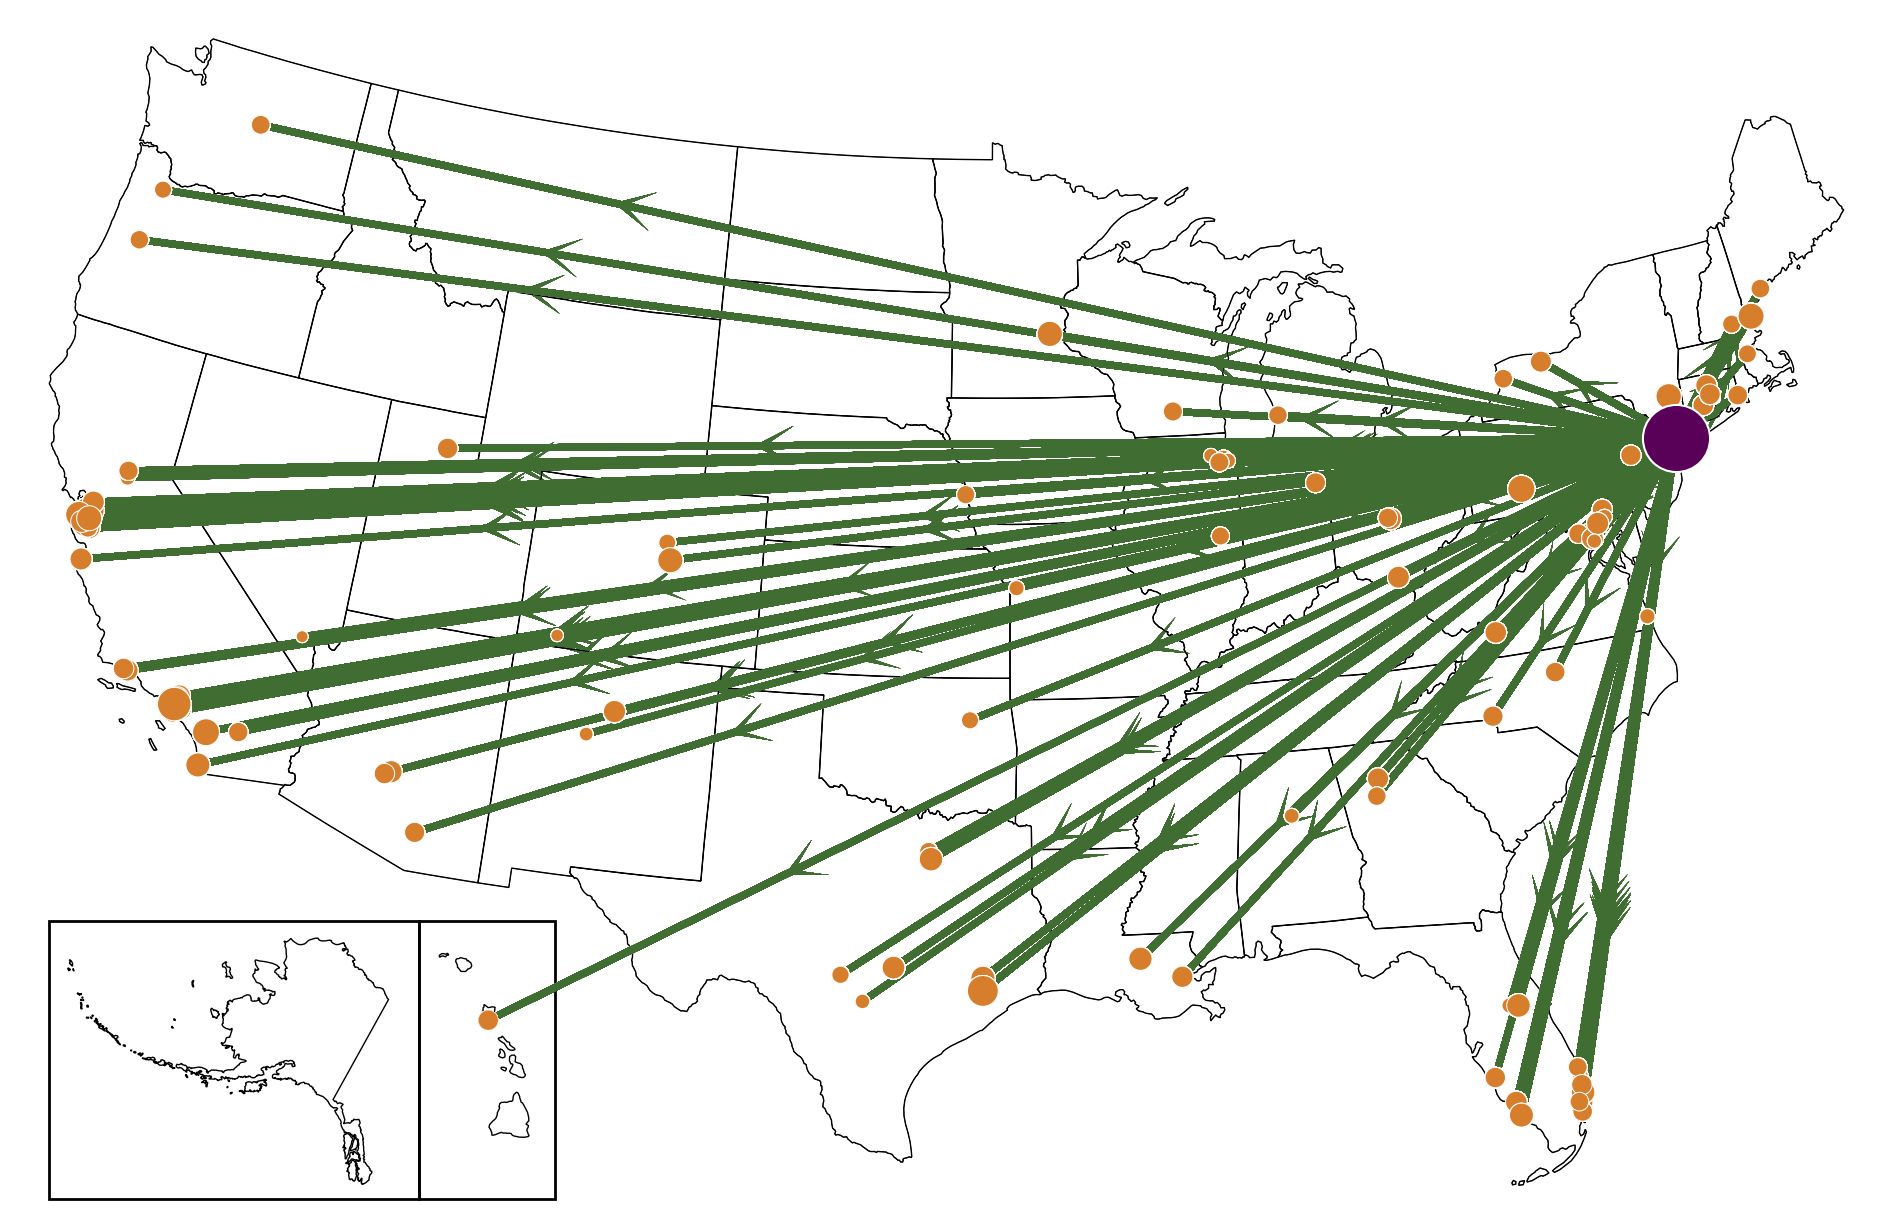

In [7]:
# Lambert Conformal map of lower 48 states.
m = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
        projection='lcc',lat_1=33,lat_2=45,lon_0=-95)

fig = plt.figure(figsize=(26.5, 15.5));
ax = fig.add_subplot(111, facecolor='w', frame_on=False);

coast_color = 'k'
state_bound_color = 'k'
state_face_color = 'white'

# draw state boundaries.
# data from U.S Census Bureau
# http://www.census.gov/geo/www/cob/st2000.html
shp_info = m.readshapefile('../data/us_shapefile/cb_2016_us_state_20m', 'states', drawbounds=True, color=coast_color)

statenames=[]
for shapedict in m.states_info:
    statename = shapedict['NAME']
    statenames.append(statename)

def alaska_correct(tup):
    (x, y) = tup
    return (0.25*x + 850000, 0.25*y - 900000)

def hawaii_correct(tup):
    (x, y) = tup
    return (0.8*x + 4200000, 0.8*y - 1000000)
    
# cycle through state names, color each one.
for nshape,seg in enumerate(m.states):
    # skip DC and Puerto Rico.
    if statenames[nshape] not in ['Puerto Rico', 'District of Columbia']:
    # Offset Alaska and Hawaii to the lower-left corner. 
        if statenames[nshape] == 'Alaska':
            # Alaska is too big. Scale it down first, then transate it. 
            seg = list(map(alaska_correct, seg))
        if statenames[nshape] == 'Hawaii':
            seg = list(map(hawaii_correct, seg))

        poly = Polygon(seg, facecolor=state_face_color, edgecolor=state_bound_color)
        ax.add_patch(poly)

ax.axis('off')

map_points_lat = from_nyc_df['lat_to']
map_points_lon = from_nyc_df['lon_to']
map_values = from_nyc_df['num_users']
nyc_lat, nyc_lon = from_nyc_df['lat'].iloc[0], from_nyc_df['lon'].iloc[0]
nyc_point = Point(m(nyc_lon, nyc_lat))

edge_widths = 0.75
line_widths = 5.

point_sizes = lambda x: np.sqrt(x)*33
# point_sizes = lambda x: x
# point_sizes = lambda x: np.log(x)*250

# Create Point objects in map coordinates from dataframe lon and lat values
map_points = pd.Series(
                [Point(m(mapped_x, mapped_y)) 
                 for mapped_x, mapped_y in zip(map_points_lon,
                                               map_points_lat)]);

# Create a scatterplot on the map
point_color = '#d77e2d' #'#33a02c'
dev = m.scatter(
            [geom.x for geom in map_points],
            [geom.y for geom in map_points],
            s=point_sizes(map_values),
            c=point_color,
            marker='o', lw=edge_widths,
            edgecolor='w',
            alpha=1.0, antialiased=True,
            zorder=3);

nyc_color = '#590059'
m.scatter(  [nyc_point.x],
            [nyc_point.y],
            s=point_sizes(from_nyc_loc_counts_df.sum()['num_users']),
            c=nyc_color,
            marker='o', lw=edge_widths*2,
            edgecolor='w',
            alpha=1.0, antialiased=True,
            zorder=3);

HI_df = from_nyc_df.dropna(subset=['to_loc'])
HI_df = HI_df[HI_df['to_loc'].str.contains(', HI')]

HI_map_points_lat = HI_df['lat_to']
HI_map_points_lon = HI_df['lon_to']
HI_values = HI_df['num_users']

hawaii_points = pd.Series(
                [Point(hawaii_correct(m(mapped_x, mapped_y)))
                 for mapped_x, mapped_y in zip(HI_map_points_lon,
                                               HI_map_points_lat)]);
m.scatter(  [geom.x for geom in hawaii_points],
            [geom.y for geom in hawaii_points],
            s=point_sizes(HI_values),
            c=point_color,
            marker='o', lw=.25,
            edgecolor='w',
            alpha=1.0, antialiased=True,
            zorder=3);

AK_df = from_nyc_df.dropna(subset=['to_loc'])
AK_df = AK_df[AK_df['to_loc'].str.contains(', AK')]

AK_map_points_lat = AK_df['lat_to']
AK_map_points_lon = AK_df['lon_to']
AK_values = AK_df['num_users']

alaska_points = pd.Series(
                [Point(alaska_correct(m(mapped_x, mapped_y)))
                 for mapped_x, mapped_y in zip(AK_map_points_lon,
                                               AK_map_points_lat)]);

m.scatter(  [geom.x for geom in alaska_points],
            [geom.y for geom in alaska_points],
            s=point_sizes(AK_values),
            c=point_color,
            marker='o', lw=.25,
            edgecolor='w',
            alpha=1.0, antialiased=True,
            zorder=3);

inset_color = 'k'
inset_width = 2
ax.add_patch(Rectangle((100000, 10000),950000,715000,linewidth=inset_width,edgecolor=inset_color,facecolor='none', zorder=2));
ax.add_patch(Rectangle((1050000, 10000),350000,715000,linewidth=inset_width,edgecolor=inset_color,facecolor='none', zorder=2));

to_plot_x = list()
to_plot_y = list()
arrow_head_dim = 100000.
arrow_color = '#3f6d32' #'darkorange'
for idx, point in enumerate(map_points):
    if ', HI' in from_nyc_df.iloc[idx]['to_loc']:
        (point_x, point_y) = hawaii_correct((point.x, point.y))
    elif ', AK' in from_nyc_df.iloc[idx]['to_loc']:
        (point_x, point_y) = alaska_correct((point.x, point.y))
    else:
        point_x = point.x
        point_y = point.y
        
#     arrow_dir = np.arctan2(point.y - nyc_point.y, point.x - nyc_point.x)
    ax.arrow(nyc_point.x, 
             nyc_point.y, 
             (point_x - nyc_point.x)*3./4.,# - (arrow_head_dim)*np.cos(arrow_dir), 
             (point_y - nyc_point.y)*3./4.,# - (arrow_head_dim)*np.sin(arrow_dir),
             length_includes_head=True,
             head_width=arrow_head_dim,
             head_length=arrow_head_dim,
             linewidth=0.,
             fc=arrow_color, ec=arrow_color, overhang=0.75)

    to_plot_x.extend([point_x, nyc_point.x, None])
    to_plot_y.extend([point_y, nyc_point.y, None])

ax.plot(to_plot_x,
        to_plot_y,
        lw=line_widths,
        alpha=1.0,
        c=arrow_color);

plt.savefig('../output/fig1d.pdf', dpi=300);